In [ ]:
import squidpy as sq
import spatialdata as sd

# Load Visium data
sdata = sd.read_zarr("../data/mouse_brain_visium_hd.sdata.zarr")
adata = sdata.tables[list(sdata.tables.keys())[0]]
visium_genes = set(adata.var_names)

# Build spatial neighbor graph on Visium grid
sq.gr.spatial_neighbors(
    adata,
    coord_type="grid",         # Visium spots lie on a hex grid
    spatial_key="spatial"        # uses adata.obspipm["spatial"]
)

c:\Users\mahsa\OneDrive\Documents\Fall2025\istarc\.istarc_hd\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
version mismatch: detected: RasterFormatV02, requested: FormatV04
c:\Users\mahsa\OneDrive\Documents\Fall2025\istarc\.istarc_hd\Lib\site-packages\zarr\creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
c:\Users\mahsa\OneDrive\Documents\Fall2025\istarc\.istarc_hd\Lib\site-packages\zarr\creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


Duplicate columns: []


In [ ]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def heat_diffuse_genes(adata, genes, n_steps=3, prefix="_heat3"):

    # Remove any existing heat columns for this prefix
    existing = [c for c in adata.obs.columns if c.endswith(prefix)]
    if existing:
        print(f"Removing {len(existing)} existing heat columns (recomputing).")
        adata.obs.drop(columns=existing, inplace=True)

    # Adjacency from Squidpy
    A = adata.obsp["spatial_connectivities"].tocsr()
    n_obs = adata.n_obs
    assert A.shape[0] == n_obs and A.shape[1] == n_obs

    # Random-walk matrix P = D^{-1} A
    deg = np.asarray(A.sum(axis=1)).ravel()
    deg[deg == 0] = 1.0
    D_inv = sp.diags(1.0 / deg)
    P = D_inv @ A

    # Expression as DataFrame once
    expr_df = adata.to_df()

    # Normalize genes argument
    genes = [str(g) for g in genes]

    heat_cols = {}

    for g in genes:
        if g not in expr_df.columns:
            # silently skip genes that are not in this dataset
            continue

        v = expr_df[g].to_numpy()
        if v.shape[0] != n_obs:
            continue

        v = v.astype(float)

        # n_steps of heat diffusion
        f = v
        for _ in range(n_steps):
            f = P @ f

        new_key = f"{g}{prefix}"
        heat_cols[new_key] = f

    if not heat_cols:
        print("Finished heat diffusion for 0 features; nothing to add.")
        return adata

    # Add all diffused columns at once
    heat_df = pd.DataFrame(heat_cols, index=adata.obs.index)
    adata.obs = pd.concat([adata.obs, heat_df], axis=1)

    print(f"Finished heat diffusion for {len(heat_cols)} genes.")
    return adata

In [ ]:
from pathlib import Path
# Marker_genes from your normalized_cellmarkers2.csv
cm_path = Path("../data/cell_markers/normalized_cellmarkers2.csv")
cm = pd.read_csv(cm_path)

marker_genes = (
    cm["marker_gene"]
      .astype(str)
      .dropna()
      .unique()
      .tolist()
)

# Only those that really exist in this Visium dataset
genes_in_data = [g for g in marker_genes if g in adata.var_names]
# Run diffusion
adata = heat_diffuse_genes(adata, genes_in_data, n_steps=3, prefix="_heat3")


Number of marker genes in this Visium dataset: 2725
Example genes: ['0610030E20Rik', '0610040J01Rik', '1110017D15Rik', '1600002K03Rik', '1700001K19Rik', '1700006F04Rik', '1700019D03Rik', '1700023F06Rik', '1700025G04Rik', '1700030K09Rik']
Finished heat diffusion for 2725 genes.


In [ ]:
import json
from pathlib import Path
import numpy as np
from PIL import Image

root = Path("../data/visium_adult_mouse_brain")
sf_path = root / "spatial" / "scalefactors_json.json"
hires_img_path = root / "spatial" / "tissue_hires_image.png"

# Load scalefactors
with open(sf_path) as f:
    sf = json.load(f)

s_hires = float(sf["tissue_hires_scalef"])
spot_diam_full = float(sf["spot_diameter_fullres"])
spot_diam_hires = spot_diam_full * s_hires

dpi = 150
size_pts2 = (spot_diam_hires * (72.0 / dpi)) ** 2

# Load hires H&E image
img_np = np.asarray(Image.open(hires_img_path))
H, W = img_np.shape[:2]

# If you had the spatial swap logic, include that too so you get spatial_key
xy_full = np.asarray(adata.obsm["spatial"], dtype=float)[:, :2]
xy_hires_guess = xy_full * s_hires
needs_swap = not ((xy_hires_guess[:, 0].max() <= W) and (xy_hires_guess[:, 1].max() <= H))
if needs_swap:
    adata.obsm["spatial_swapped"] = xy_full[:, [1, 0]]
    spatial_key = "spatial_swapped"
else:
    spatial_key = "spatial"


In [6]:
type(adata)

anndata._core.anndata.AnnData

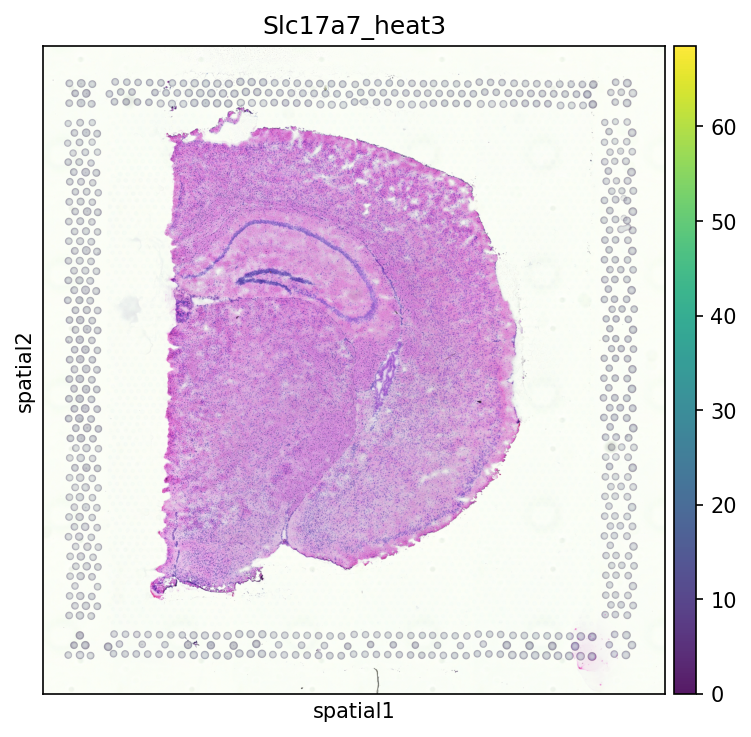

In [ ]:
import pandas as pd

col = "Slc17a7_heat3"   # whichever gene_heat you want to plot

vals_series = adata.obs[col]
if isinstance(vals_series, pd.DataFrame):
    # Take the first column if duplicates somehow appear
    vals_series = vals_series.iloc[:, 0]

adata.obs[col] = pd.to_numeric(vals_series, errors="coerce")


sq.pl.spatial_scatter(
    adata,
    color=col,
    img=img_np,
    size=size_pts2,
    alpha=0.9,
    dpi=dpi,
    spatial_key=spatial_key,
)

In [ ]:
# Save as h5ad for Starfysh
adata.write_h5ad("../data/visium_mouse_brain_heat.h5ad")
np.save("../data/visium_mouse_brain_img.npy", img_np)